# E6 - Bleaching Correction

## 1. Introduction

#### Technical background
In our [preivous work](https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-11-2-554&id=425585), we have shown that the $n^{th}$ order SOFI cumulant image can be interpreted as an image formed by virtual emitters imaged by an imaging system with a virtual point spread function. The locations of the virtual emitters are the same as the real emitters in the sample, while the brightnesses of the virtual emitters (i.e. the virtual brightneses) are different and can poccess either positive or negative values based on their blinking statistics. The mixture of negative and positive virtual emitters would cause the 'cusp' artifacts in the SOFI images. To get familiar with cusp-artifacts and the effect of mixed postive- and negative- virtual brightnesses, please refer to our [preivous work](https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-11-2-554&id=425585), and start with our [demo 1](https://github.com/xiyuyi-at-LLNL/pysofi/blob/master/Notebooks/CuspArtifactsDemo1_3Emitters.ipynb) and [demo 2](https://github.com/xiyuyi-at-LLNL/pysofi/blob/master/Notebooks/CuspArtifactsDemo2_SlowVaryingRho.ipynb). In summary, we have derived the theoretical prediction of the emitter virtual brightnesses as a function of the blinking rates in the [preivous work](https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-11-2-554&id=425585). However, photobleaching can introduce errors in the such virtual brightnesses, causing the resultant high order SOFI image to deviate from the theoretical values. The effect of the bleaching correction step is to restore the theoretical virtual brightnesses back to the model prediction.

The details of the bleaching correction algorithm is explained in appendix 3.1 of this [paper](https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-11-2-554&id=425585). In brief, the input .tiff stack is divided into different segments determined by a parameter called the bleaching correction factor ($f_{bc}$), and the time avarege of each segment of the movie is subtracted from the corresponding segment independently, resulting into a new .tiff stack where the bleaching effect is removed.

#### What's included in this notebook
This notebook demonstrates how to perfrom bleaching correction of a tiff stack in the pysofi package with two options. One option (section 3) is to perfrom the bleaching correction through the PysofiData class and is useful when one wants to use it in the existing SOFI analysis workflow we implemented in the PysofiData class. The second option (section 4) is to use it by directly importing and using the relevant function module (reconstruction.py). This option is useful when one would like to perform the Fourier interpolation as a standalone processing step in your own data analysis workflow. 

#### Relevant dataset
The datafiles used in the examples (Jupyter Notebooks) are included in the *exampledata* folder in the **pysofi** repository and the our [figshare site](https://figshare.com/s/47d97a2df930380c96bb). In this notebook, we use two simulation datasets available on the [figshare site](https://figshare.com/s/47d97a2df930380c96bb). To demonstrates the effect of bleaching correction, both consists of 51 emitters distributed along a half-circle structure with slowly varying 'on'-time ratio ($\rho$) values ranging from 0 to 1 from one side to the other. The first dataset contains emitters without photobleaching ('SlowVaryingRho_frame2000_Emi51_InterpNum8.tif'), and the second dataset contains emittesr with photobleaching ('Bleach_SlowVaryingRho_frame2000_Emi51_InterpNum8.tif'). We demonstrate how to perform the photo-bleaching correction on the second dataset and show the effect by comparing the results to the results on the first dataset. Please download the relevant datafiles, and put them under the 'exampledata/simulations' folder of the downloaded repository for the demonstrations in this notebook.



## 2. Import all the tools and inspect the datasets
Before we begin, let's first import all the relevant packages and modules.

#### 2.1. import all the tools

In [2]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from pysofi import (reconstruction, filtering, pysofi)
import tifffile as tiff
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 2.2. Inspect the bleaching effect

First, let us compare the signal intensity change for the two datasets (i.e. with and without photobleaching). First, we define the file names and file paths:

In [2]:
filepath = '../sampledata/simulations'
filename_bleach = 'Bleach_SlowVaryingRho_frame2000_Emi51.tif'
filename_nobleach = 'SlowVaryingRho_frame2000_Emi51.tif'

we then caculate the time evolution of the total signal from each image frame for both datasets, and obtained the photo-bleaching profile by applying a smooth filter to time evolution of the total signal:

In [3]:
# Get the total signal from each image frame as a funciton of time.
signal_bleach = reconstruction.calc_total_signal(filepath, filename_bleach)
signal_nobleach = reconstruction.calc_total_signal(filepath, filename_nobleach)
# Perform median filtering to the total signal to obtain the bleaching profile
filtered_signal_bleach = filtering.med_smooth(signal_bleach, kernel_size=251)
filtered_signal_nobleach = filtering.med_smooth(signal_nobleach, kernel_size=251)

we can now visualize the bleaching profile

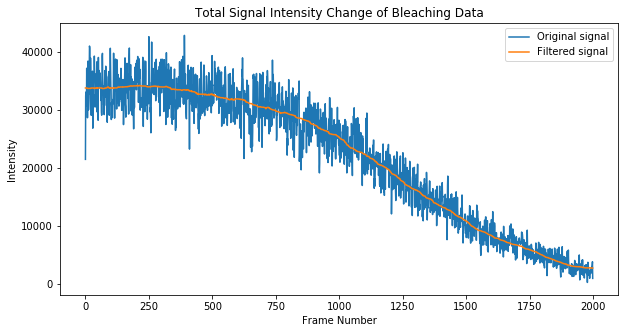

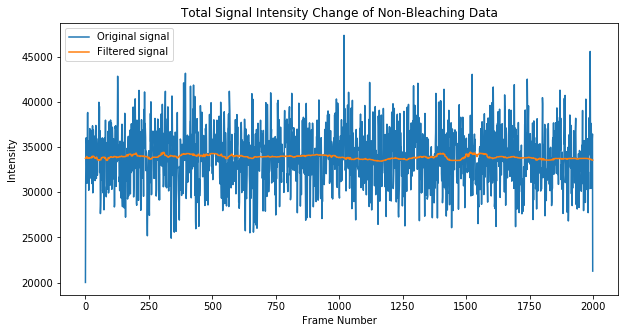

In [4]:
# Plot and compare signal changes for data with / without photobleaching
plt.figure(figsize=(10,5))
plt.plot(signal_bleach, label='Original signal')
plt.plot(filtered_signal_bleach, label='Filtered signal')
plt.xlabel('Frame Number')
plt.ylabel('Intensity')
plt.title('Total Signal Intensity Change of Bleaching Data')
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(signal_nobleach, label='Original signal')
plt.plot(filtered_signal_nobleach, label='Filtered signal')
plt.xlabel('Frame Number')
plt.ylabel('Intensity')
plt.title('Total Signal Intensity Change of Non-Bleaching Data')
plt.legend()

The high frequency components (blue) are filtered-out using <code>filtering.med_smooth</code> to obtain a smoothed time evolution of average signal (orange). The user can tune <code>kernel_size</code> to achieve optimal filtered signal.

As we can see from the plots above, if no emitter is bleached throughout the whole video, then the total signal intensity stays at a fixed value (with small oscillations), while total intensity decays with photobleaching. 

#### 2.3. The effect of photobleaching on the cumulant images

Photobleaching would cause on-time-ratio $\rho$ to deviate from its estimated value from the blinking model without photo-bleaching. In the blinking model, the 'bleached' state is equivalent to an ultralong 'off' state, causing a decrease in $\rho$ values.  

Here we demonstrate the effect of photobleaching on the cumulant images, by calculating the cumulants (without photo-bleaching correction) on the two datasets taht either with or without photobleaching.


In [5]:
# load the dataset with bleaching into a PysofiData class object d_bleach
d_bleach = pysofi.PysofiData(filepath, filename_bleach)
# calculate the 7th order cumulant
k_set_bleach = d_bleach.cumulants_images(highest_order=7)


# load the dataset without bleaching into a PysofiData class object d_bleach
d_nobleach = pysofi.PysofiData(filepath, filename_nobleach)
# calculate the 7th order cumulant
k_set_nobleach = d_nobleach.cumulants_images(highest_order=7)

Calculating the 1st-order moment...
[==============================] 100.0%

Calculating the 2nd-order moment...
[==============================] 100.0%

Calculating the 3rd-order moment...
[==============================] 100.0%

Calculating the 4th-order moment...
[==============================] 100.0%

Calculating the 5th-order moment...
[==============================] 100.0%

Calculating the 6th-order moment...
[==============================] 100.0%

Calculating the 7th-order moment...
[==============================] 100.0%

Calculating the 1st-order moment...
[==============================] 100.0%

Calculating the 2nd-order moment...
[==============================] 100.0%

Calculating the 3rd-order moment...
[==============================] 100.0%

Calculating the 4th-order moment...
[==============================] 100.0%

Calculating the 5th-order moment...
[==============================] 100.0%

Calculating the 6th-order moment...
[==============================] 100.0%


we can now inspect the cumulant images from the dataset with photobleaching, and compare it to the cumulant images calculated from the dataset without photobleaching, and notice the difference.

We first plot the cumulant imates for dats with photolbeaching:

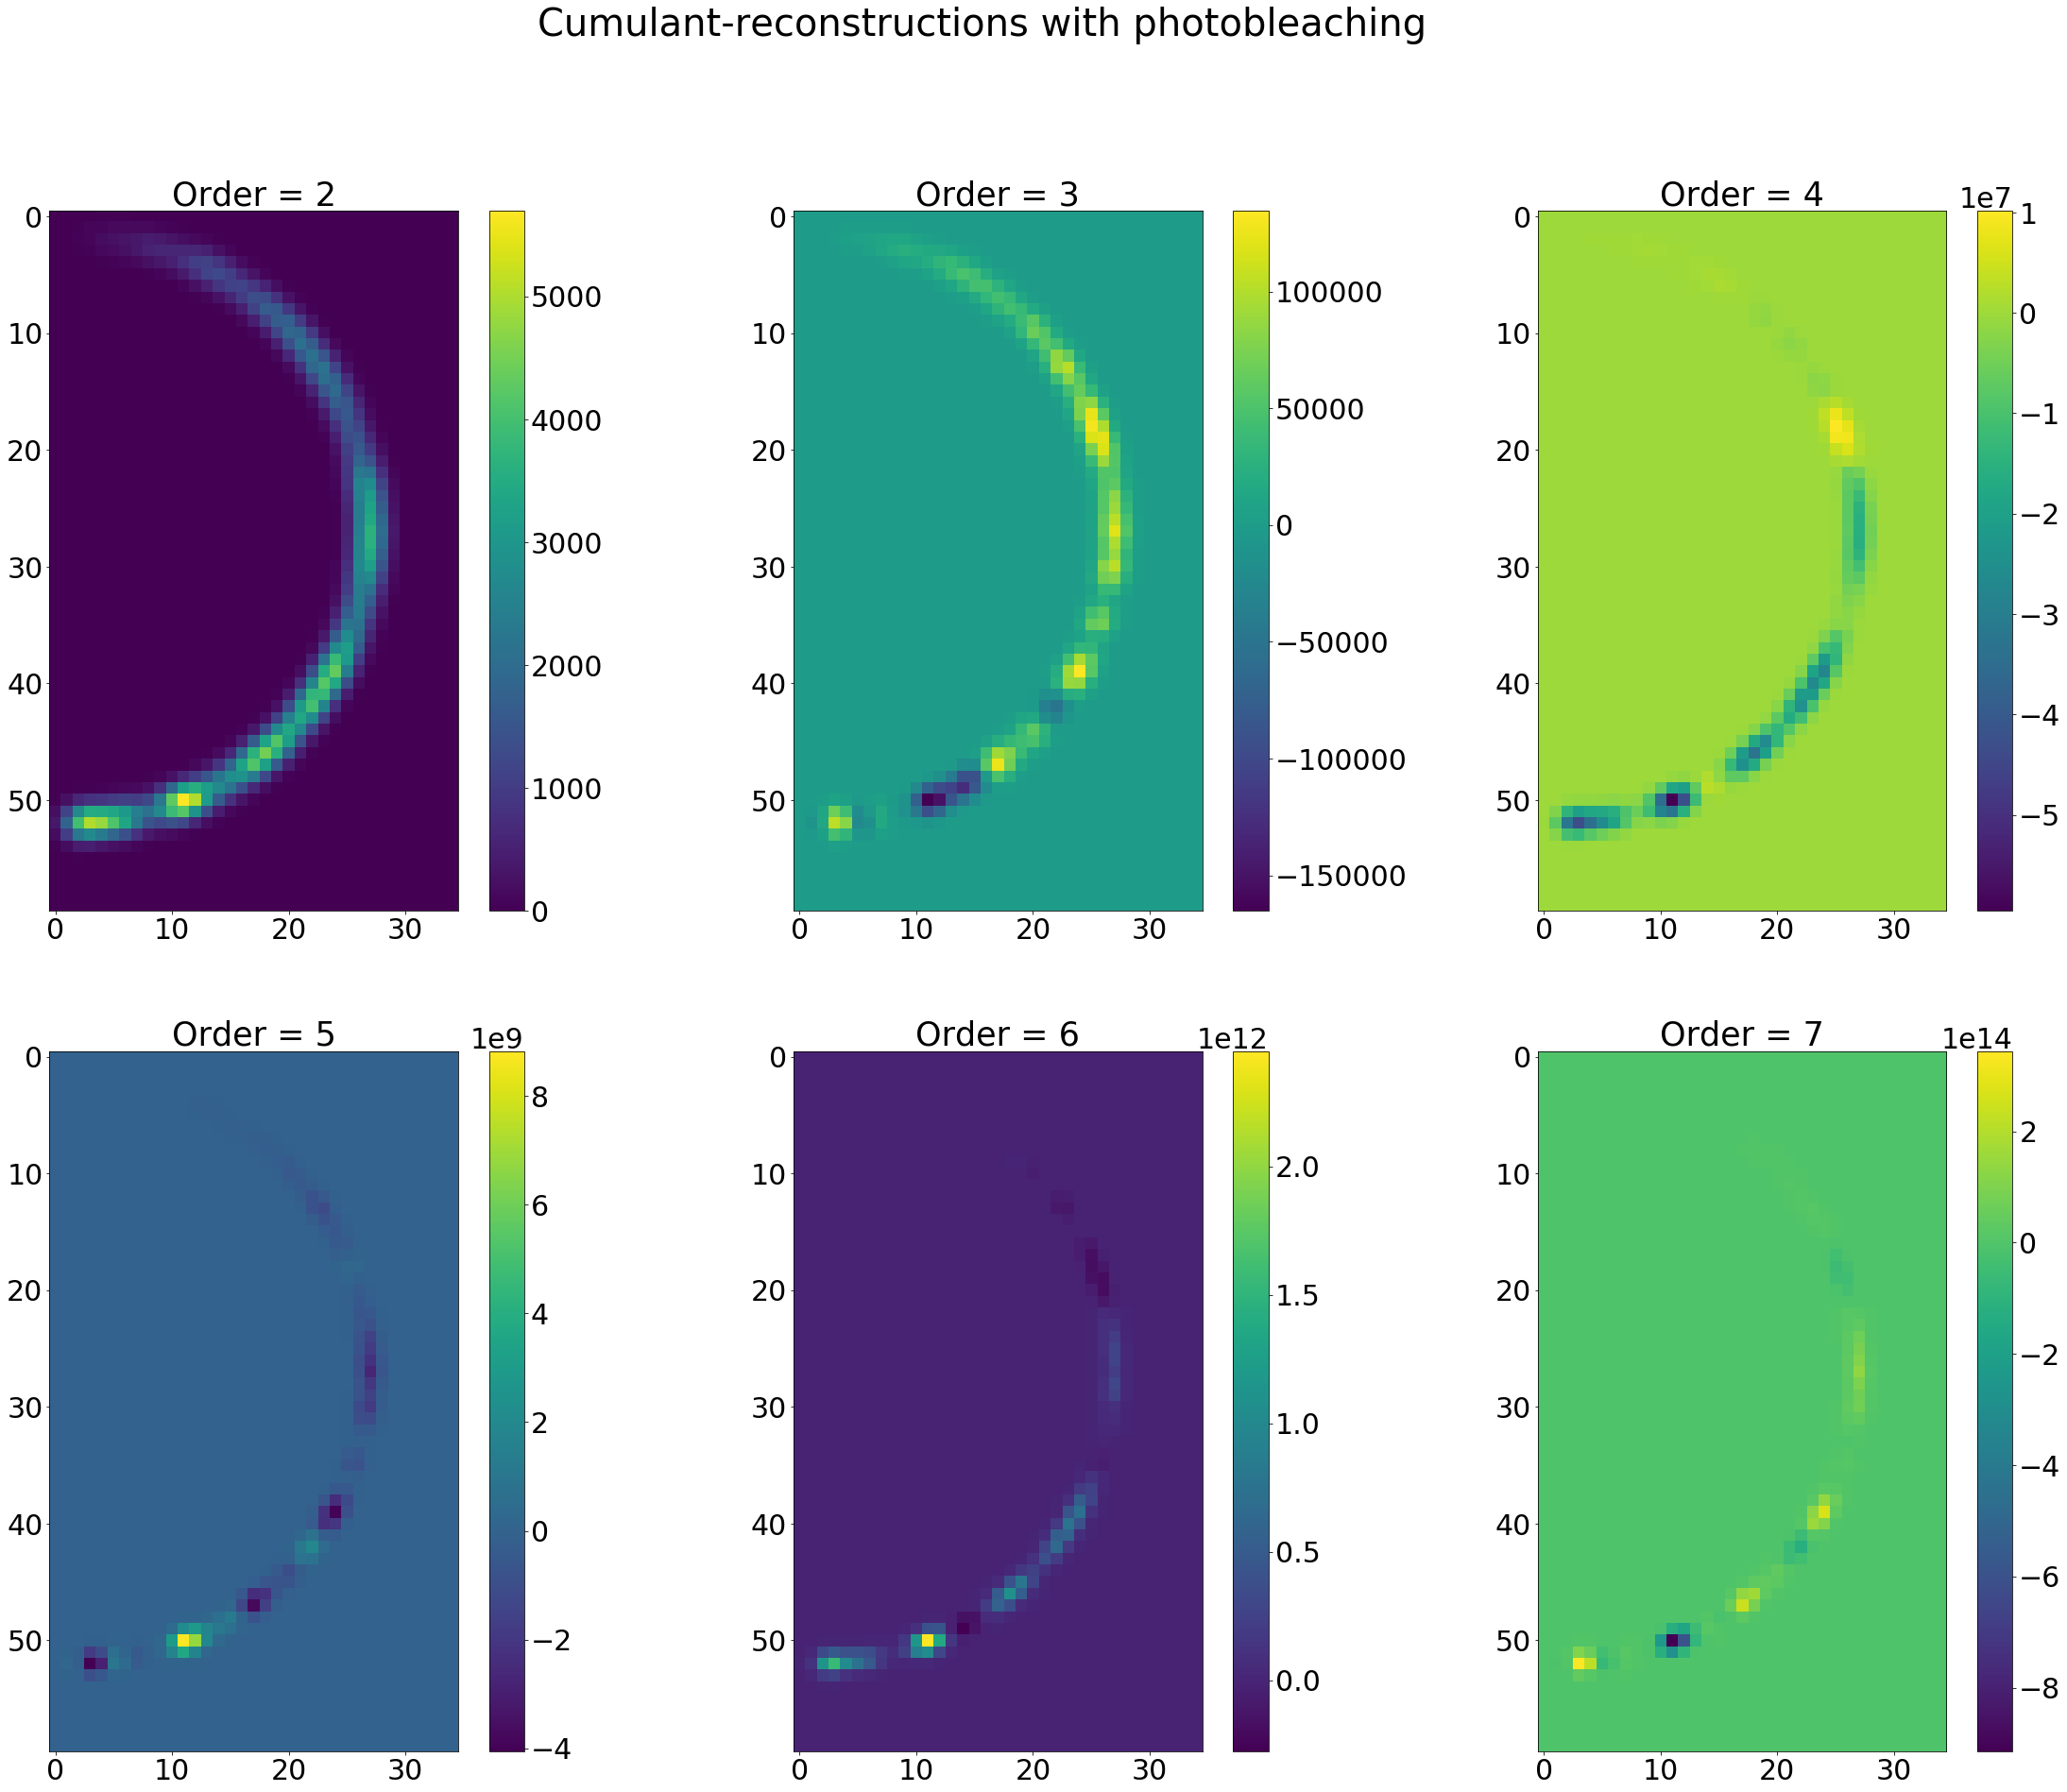

In [6]:
# Plot reconstructions for data with photobleaching
fig, axs = plt.subplots(2,3,figsize=(40,30))
fig.suptitle("Cumulant-reconstructions with photobleaching", fontsize=40)
for i in range(2,8):
    row = (i - 2) // 3
    ax = axs[row,i-2-row*3]
    img = ax.imshow(k_set_bleach[i]*0.8)
    ax.tick_params(axis='x', labelsize= 30)
    ax.tick_params(axis='y', labelsize= 30)
    ax.set_title(f'Order = {i}', fontsize=35)
    cb = plt.colorbar(img, ax=ax)
    cb.ax.tick_params(labelsize=30)
    cb.ax.yaxis.get_offset_text().set_fontsize(30)

we then show the cumulant images from data without photobleaching;

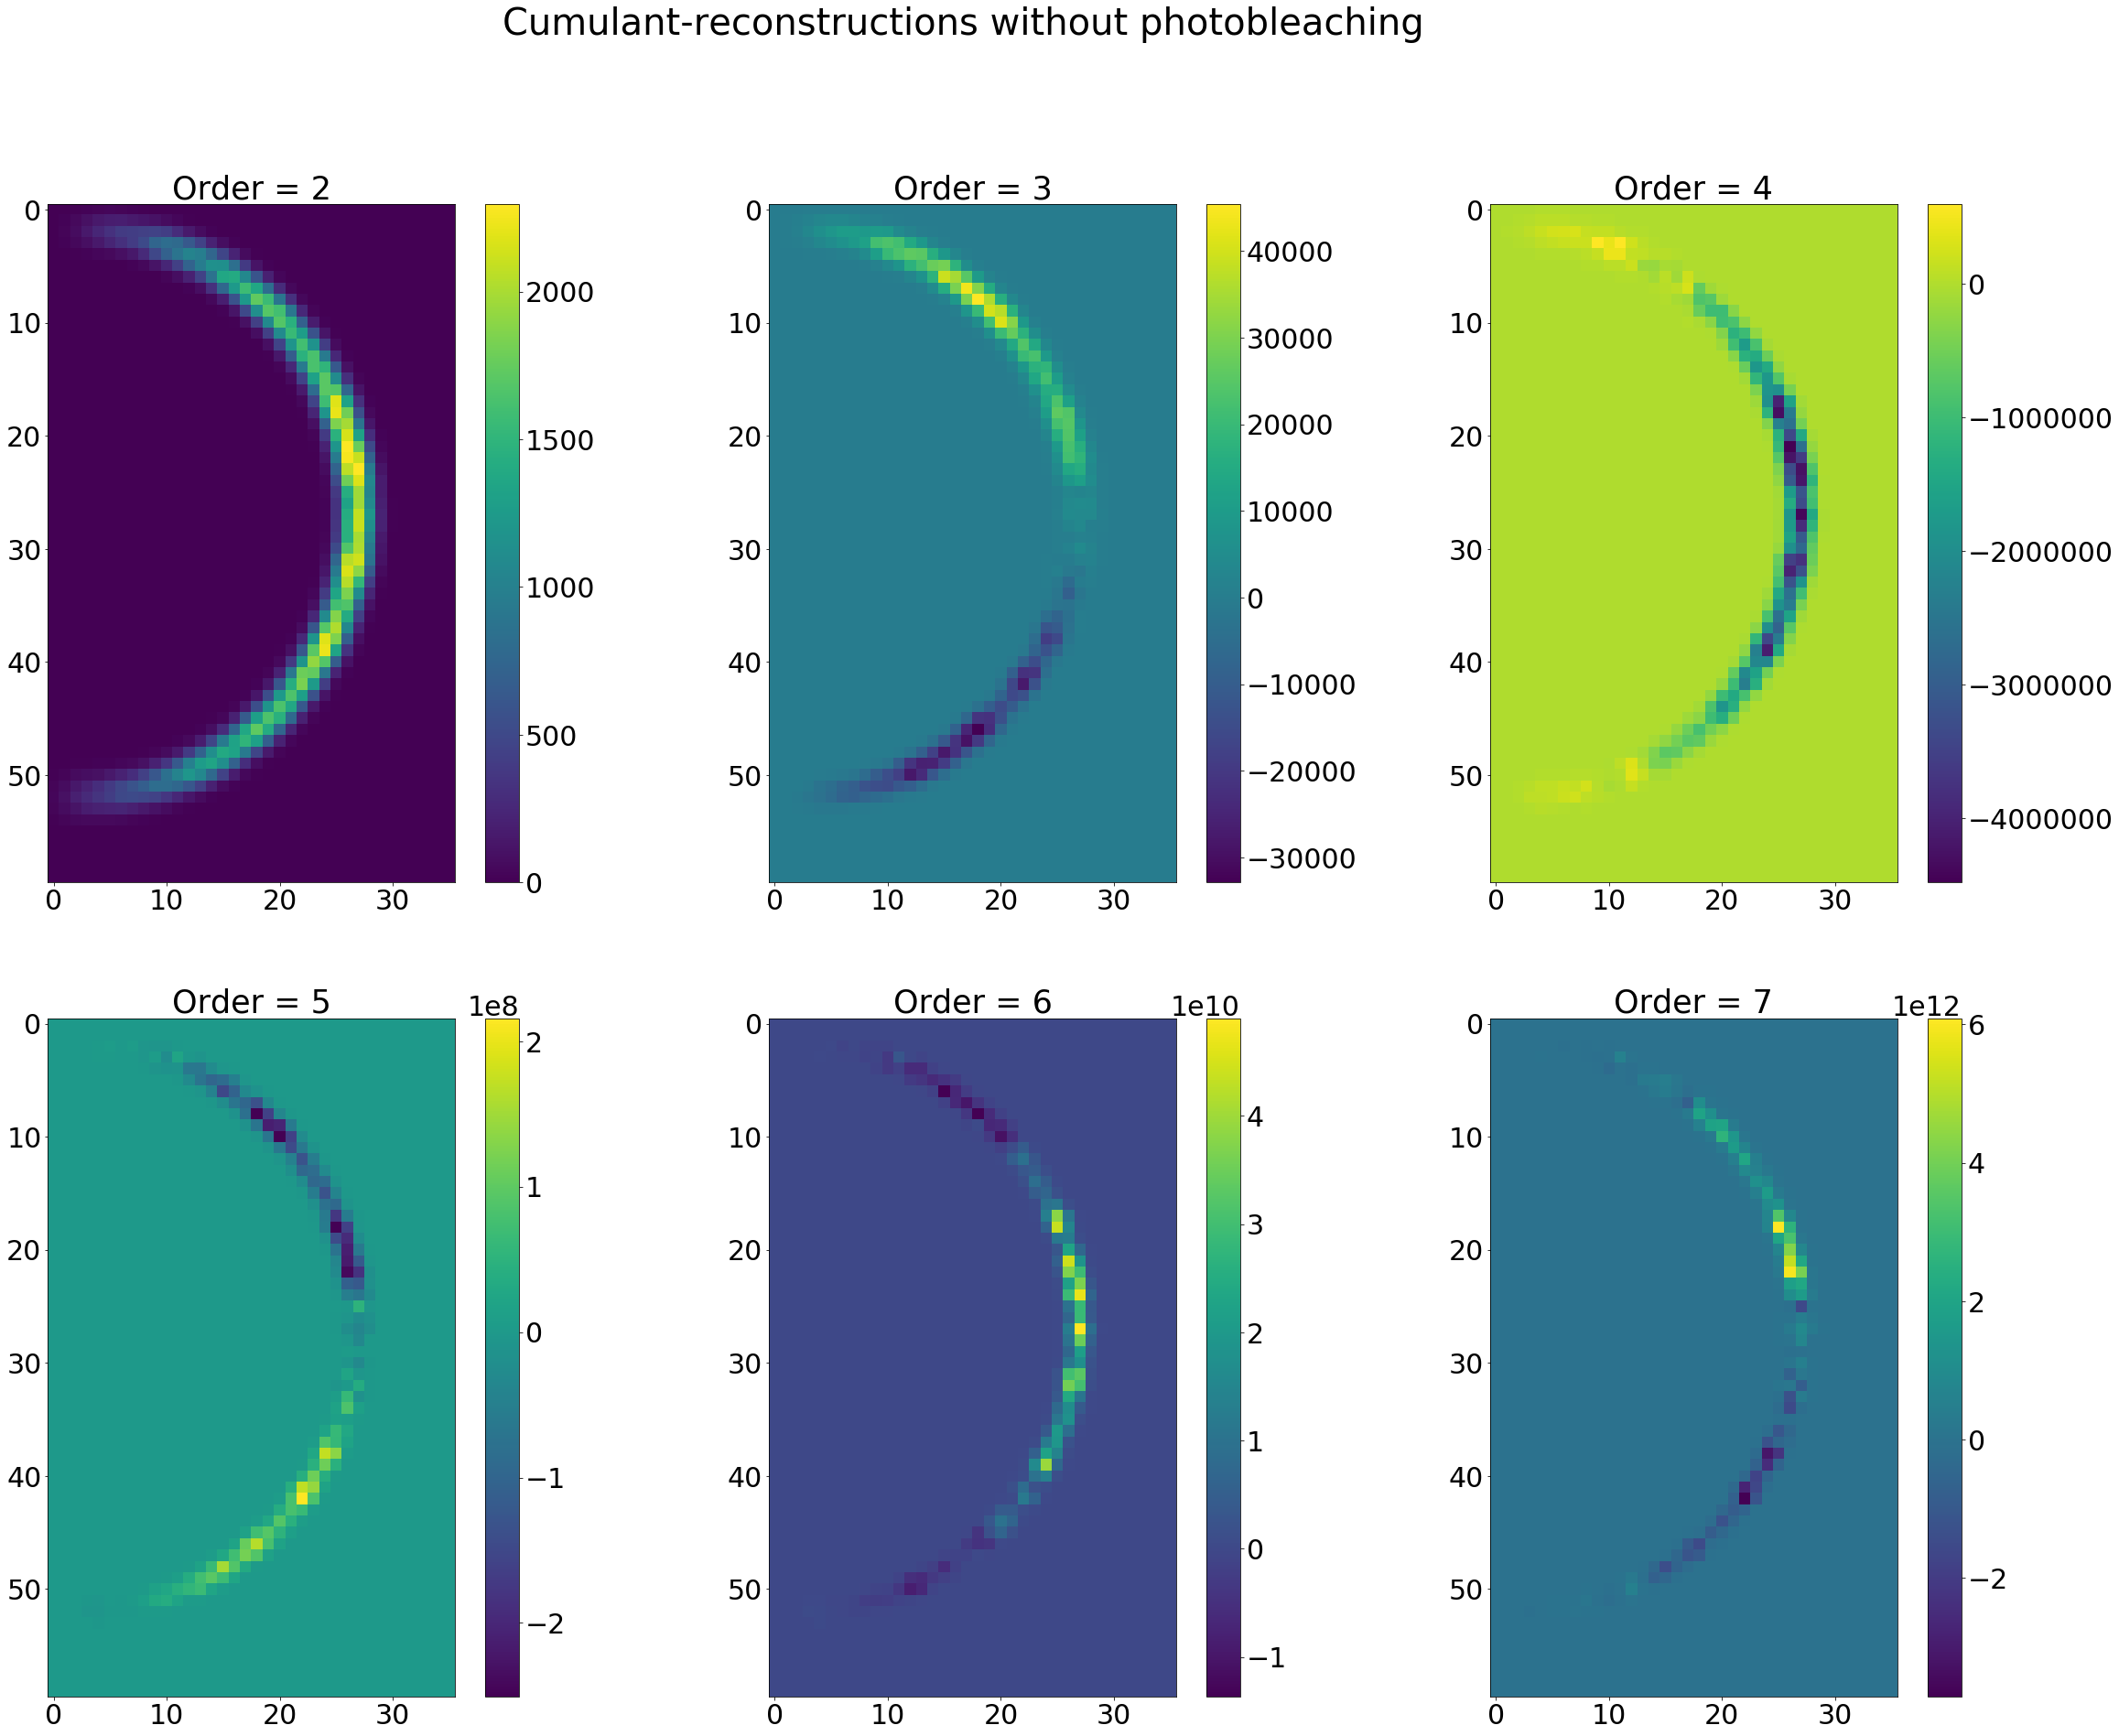

In [7]:
# Plot reconstructions for data without photobleaching
fig, axs = plt.subplots(2,3,figsize=(40,30))
fig.suptitle("Cumulant-reconstructions without photobleaching", fontsize=40)
for i in range(2,8):
    row = (i - 2) // 3
    ax = axs[row,i-2-row*3]
    img = ax.imshow(k_set_nobleach[i]*0.8)
    ax.tick_params(axis='x', labelsize= 30)
    ax.tick_params(axis='y', labelsize= 30)
    ax.set_title(f'Order = {i}', fontsize=35)
    cb = plt.colorbar(img, ax=ax)
    cb.ax.tick_params(labelsize=30)
    cb.ax.yaxis.get_offset_text().set_fontsize(30)

we can see that the images are different between the results from datasets with and without photobleaching, and the difference is caused by the bleaching effect. 

We can put the same order cumulants from two datasetes side-by-side for better comparison:

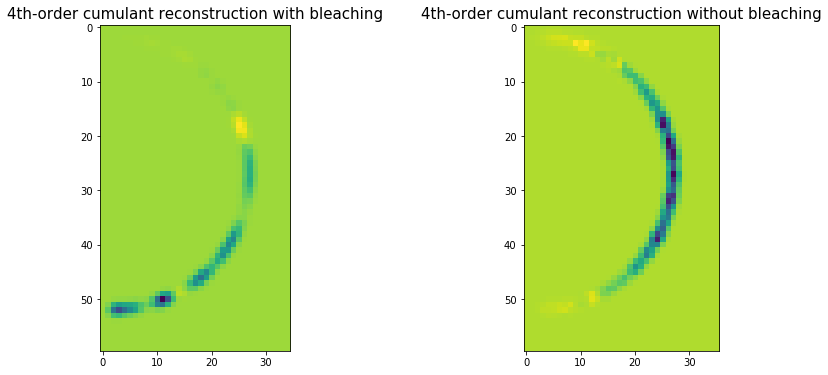

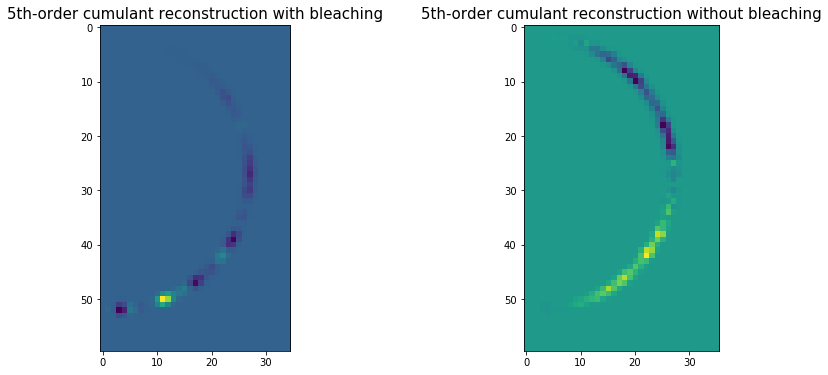

In [8]:
# Compare reconstructions of the same order
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))
axs[0].set_title('4th-order cumulant reconstruction with bleaching', fontsize=15)
axs[0].imshow(k_set_bleach[4])
axs[1].set_title('4th-order cumulant reconstruction without bleaching',fontsize=15)
axs[1].imshow(k_set_nobleach[4])

fig, axs = plt.subplots(ncols=2, figsize=(14, 6))
axs[0].set_title('5th-order cumulant reconstruction with bleaching', fontsize=15)
axs[0].imshow(k_set_bleach[5])
axs[1].set_title('5th-order cumulant reconstruction without bleaching',fontsize=15)
axs[1].imshow(k_set_nobleach[5])
plt.show()

## 3. Use <code>PysofiData</code> class for the photobleaching correction 

Here we demonstrate how to perform photobleaching correction using the workflow implemented in the <code>PysofiData</code> class. The implementation is realized simply by setting the parameter <code>bleach_correction</code> to be <code>True</code> in the method to calculate the cumulant image, as shown below:

In [9]:
# SOFI-process photobleaching data with bleaching correction (fbc=0.04)
k_set_bleach_corrected = d_bleach.cumulants_images(highest_order=7, bleach_correction=True,
                                          smooth_kernel=251, fbc=0.04)

Calculating moments of block 0...
[==============================] 100.0%

Calculating moments of block 1...
[==============================] 100.0%

Calculating moments of block 2...
[==============================] 100.0%

Calculating moments of block 3...
[==============================] 100.0%

Calculating moments of block 4...
[==============================] 100.0%

Calculating moments of block 5...
[==============================] 100.0%

Calculating moments of block 6...
[==============================] 100.0%

Calculating moments of block 7...
[==============================] 100.0%

Calculating moments of block 8...
[==============================] 100.0%

Calculating moments of block 9...
[==============================] 100.0%

Calculating moments of block 10...
[==============================] 100.0%

Calculating moments of block 11...
[==============================] 100.0%

Calculating moments of block 12...
[==============================] 100.0%

Calculating moments of

Please note that the parameter <code>fbc</code> is the bleahcing correction factor defined in appendix 3.1 of this [paper](https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-11-2-554&id=425585). We recommend the users to use simulations to optimize the choice of this parameter.

Now if we compare the cumulant images 


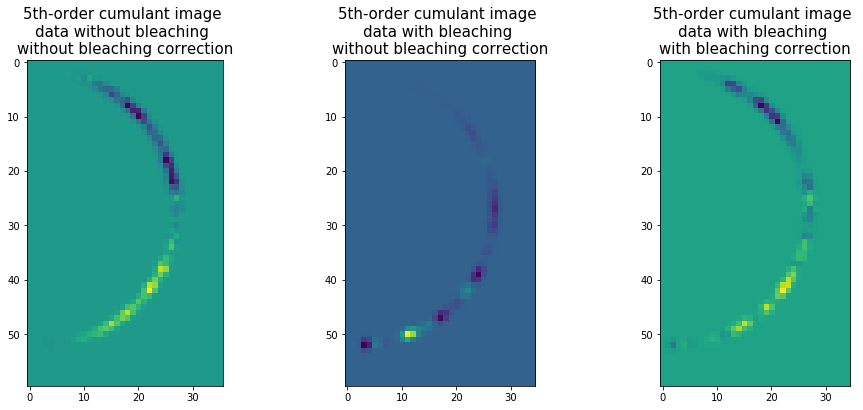

In [10]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 6))
axs[0].set_title('5th-order cumulant image \n'+
                 'data without bleaching \n'
                 'without bleaching correction',fontsize=15)
axs[0].imshow(k_set_nobleach[5])
axs[1].set_title('5th-order cumulant image \n'+
                'data with bleaching \n'
                 'without bleaching correction', fontsize=15)
axs[1].imshow(k_set_bleach[5])
axs[2].set_title('5th-order cumulant image \n'+
                 'data with bleaching \n'+
                 'with bleaching correction',fontsize=15)
axs[2].imshow(k_set_bleach_corrected[5])
plt.show()

The left image is the 5th order cumulant image calculated from the first dataset (without photobleaching). The cumulant value resembles the cumulant value distribution as predicted from the model. 

The middle image is the 5th order cumulant image calculated from the second dataset (with photo bleaching) witout bleaching correction. We can see that the cumulant values greatly deviate from the first image, meaning that the bleaching effect is influencing the calcualted cumulant values. 

In the right image, the cumulant image is also calcualted the second dataset, but the bleaching correction function is enabled.  We can see that the cumulant images resembles the image shown in the left image, suggesting that the effect of photobleaching on the calculated cumulant image is removed.


## 4. Use the <code>reconstruction.py</code> module for the photobleaching correction 

Another way to use the photo bleaching is to use it by directly importing the <code>reconstruction.py</code> module. 

In [11]:
from functions import reconstruction as r
filepath = '../sampledata/simulations'
filename_bleach = 'Bleach_SlowVaryingRho_frame2000_Emi51.tif'
r.correct_bleaching(filepath, filename_bleach, fbc=0.04, smooth_kernel=251,
                      save_option=True, return_option=False)

in the example above, we are taking the TIFF stack that contains bleaching effect, and perform bleaching correction to it, and save out the bleach-corrected TIFF stack out into a new TIFF stack with the file name appended with '_bc'. 

In this case, the file name of the bleach-corrected TIFF stack would be 'Bleach_SlowVaryingRho_frame2000_Emi51_bc.tif'.




## 5. Discussion 

There are two parameters involved in the bleaching correction step. The first is the <code>smooth_kernel</code> that defines the median filter size on the time evolution of the average signal per frame to generate the bleaching profile curve. Empricially, we choose the smallest allowable kernal size that produces a monotinically decreasing bleaching profile. 

The second parameter is the bleaching correction factor <code>fbc</code>, which is [shown](https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-11-2-554&id=425585) to be insensitive within the range from 0.0025 to 0.04 for our simulation datasets. However, for application on experimental datasets, we suggest the user to use simulations to verify the choice of the <code>fbc</code> value. Specifically, one can generate a pair of simulation datasets that mimic the experimental conditions such as signal level, feature type, etc. Additionally, included bleaching effect in one of the simulations, while leaving the bleaching effect out for the other. The effectiveness of the chosen <code>fbc</code> value can then be veryfied by making sure the bleaching correction can truely remove the bleacihng effect and produce similar cumulant images for both bleaching and non-bleaching conditions.
